# Trabajo Práctico 2: Reseñas de Películas - XGBoost

## Grupo 11 - "Los Outliers"

- Castillo, Carlos
- Destefanis, Juan Pablo
- Gómez, Celeste

# Dependencias

In [ ]:
!pip install nltk
!python -m spacy download es_core_news_sm
!python -m spacy download es

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.9/12.9 MB 16.5 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('es_core_news_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.
⚠ As of spaCy v3.0, shortcuts like 'es' are deprecated. Please use the
full pipeline package name 'es_core_news_sm' instead.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.9/12.9 MB 24.1 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('es_core_news_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


In [ ]:
!pip install unidecode

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 235.5/235.5 kB 2.2 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
import seaborn as sns

import nltk
import spacy

from sklearn.model_selection import cross_val_score, RandomizedSearchCV, GridSearchCV, StratifiedKFold
from sklearn.metrics import make_scorer, f1_score
import xgboost as xgb

import re
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
from nltk.tokenize import ToktokTokenizer
from nltk.tokenize import word_tokenize
from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix, classification_report

from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.pipeline import make_pipeline

from joblib import dump, load
from os.path import exists

In [ ]:
from unidecode import unidecode

In [ ]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [ ]:
nlp = spacy.load('es_core_news_sm')

In [ ]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

# Carga de datos

Cargo el dataset de entrenamiento

In [ ]:
df_train = pd.read_csv("https://drive.usercontent.google.com/u/1/uc?id=17JRXErnbhnHxhD8Z8AFfOP4fJnkivu0-&export=download", index_col=0)

Cargo el dataset de testing

In [ ]:
df_test = pd.read_csv("https://drive.usercontent.google.com/u/1/uc?id=1HtgxC7iumrAXTsaAS6Qkp0w25eerGc4w&export=download", index_col=0)

# Vectorizer

In [ ]:
def metricas(y_pred,y_test):

  print(classification_report(y_test,y_pred))

  cm = confusion_matrix(y_test,y_pred)
  sns.heatmap(cm, cmap='Blues',annot=True,fmt='g')
  plt.xlabel('Predicted')
  plt.ylabel('True')

In [ ]:
sentimiento_a_string = np.vectorize(lambda x: 'negativo' if x == 0 else 'positivo')

## Bag of Words

Hago una copia del dataset.

In [ ]:
df_trabajo = df_train.copy()

Transformo los textos a minusculas, elimino diacríticos y tokenizo dejando solo palabras para formar un texto normalizado.

In [ ]:
def limpiar_texto(texto):

  texto = texto.lower()

  # texto = unidecode(texto)

  return texto

In [ ]:
def tokenizar(texto):
  # tokenizar un texto y dejar solo palabras
  tokens = [w.text for w in nlp.tokenizer(texto)]

  tokens = [token.lower() for token in tokens if token.isalpha()]

  return tokens

Genero una lista de stopwords en Español.

In [ ]:
stoplist = stopwords.words("spanish")

In [ ]:
stoplist_tokenized = []
for w in stoplist:
    stoplist_tokenized = stoplist_tokenized + tokenizar(w)

In [ ]:
stopword_list_tokenized = list(set(stoplist_tokenized))

Ahora entreno el CountVectorizer para armar la bag of words.

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(df_trabajo.review_es, df_trabajo.sentimiento, test_size=0.2, random_state=13, stratify=df_trabajo.sentimiento)

XGBoost no permite las categorias como "positive" y "negative", por eso debo transformarlas a 0 y 1. Tomo 1 como "positive" y 0 como "negative".

In [ ]:
y_train_num = y_train.map(lambda x: 0 if x == 'negativo' else 1)
y_test_num = y_test.map(lambda x: 0 if x == 'negativo' else 1)

Creo la grilla de híperparametros.

In [ ]:
params_grid = {
  'booster': ['gbtree'],
  'n_estimators': range(1, 50),
  'max_depth': range(1, 25),
  'learning_rate': np.linspace(0, 1, 300),
  'min_child_weight': range(1, 8),
  'colsample_bytree': np.linspace(0, 1),
  'reg_alpha': np.linspace(0, 1),
  'reg_lambda': np.linspace(0, 1)
}

Creo la bag of words.

In [ ]:
vec = CountVectorizer(preprocessor=limpiar_texto,
                      tokenizer=tokenizar,
                      stop_words=stopword_list_tokenized)

X_train_bag = vec.fit_transform(X_train)
X_test_bag = vec.transform(X_test)

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


Entreno con cross validation.

In [ ]:
xgb_base = xgb.XGBClassifier()

if exists('xgb_lower_token_stopword_countvectorizer.joblib') == False:
  randomcv = RandomizedSearchCV(xgb_base,
                                params_grid,
                                cv=5,
                                scoring='f1_micro',
                                n_iter=2,
                                random_state=13)

  randomcv_prueba = randomcv.fit(X_train_bag, y_train_num)

  print(str(randomcv_prueba.best_params_))
  print(str(randomcv_prueba.best_score_))
else:
  xgb_model_countvec = load('xgb_lower_token_stopword_countvectorizer.joblib')

In [ ]:
if exists('xgb_lower_token_stopword_countvectorizer.joblib') == False:
  xgb_model_countvec = xgb.XGBClassifier()

  xgb_model_countvec.set_params(**randomcv_prueba.best_params_)

xgb_model_countvec.fit(X_train_bag, y_train_num)
y_pred_test = xgb_model_countvec.predict(X_test_bag)

              precision    recall  f1-score   support

           0       0.82      0.81      0.82      5000
           1       0.82      0.82      0.82      5000

    accuracy                           0.82     10000
   macro avg       0.82      0.82      0.82     10000
weighted avg       0.82      0.82      0.82     10000



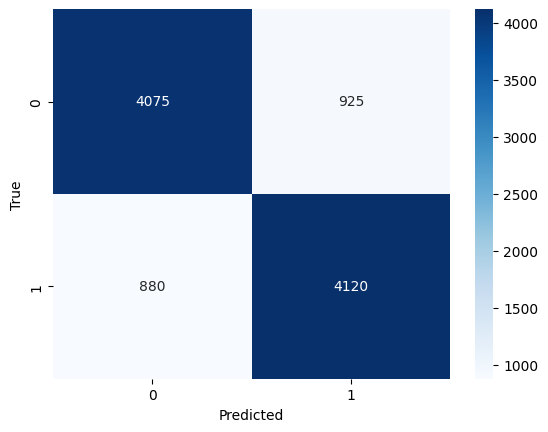

In [ ]:
metricas(y_pred_test, y_test_num)

Transformo las reviews de tests

In [ ]:
X_test_real = vec.transform(df_test["review_es"])

Hago las predicciones

In [ ]:
y_test_pred_real = xgb_model_countvec.predict(X_test_real)

In [ ]:
y_pred_real = sentimiento_a_string(y_test_pred_real)

Inlcuyo las predicciones en el dataframe de test

In [ ]:
df_test["sentimiento"] = y_pred_real

df_export = df_test.copy()

Quito la columna de reviews

In [ ]:
df_export.drop(["review_es"], axis="columns", inplace=True)

Exporto las predicciones

In [ ]:
if exists('xgb_lower_token_stopword_countvectorizer.csv') == False:
  df_export.to_csv("xgb_lower_token_stopword_countvectorizer.csv")

Exporto el modelo

In [ ]:
if exists('xgb_lower_token_stopword_countvectorizer.joblib') == False:
  dump(xgb_model_countvec, 'xgb_lower_token_stopword_countvectorizer.joblib')

# TFIDF

Ahora pruebo con TFIDF para ver el impacto sobre las predicciones.

In [ ]:
tfidfvec = TfidfVectorizer(preprocessor=limpiar_texto,
                      tokenizer=tokenizar,
                      stop_words=stopword_list_tokenized)

X_train_bag = tfidfvec.fit_transform(X_train)
X_test_bag = tfidfvec.transform(X_test)
X_real = tfidfvec.transform(df_test["review_es"])

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


In [ ]:
xgb_base = xgb.XGBClassifier(device="cuda")

if exists('xgb_lower_token_stopwords_tfidf.joblib') == False:
  randomcv = RandomizedSearchCV(xgb_base,
                                params_grid,
                                cv=5,
                                scoring='f1_micro',
                                n_iter=5,
                                random_state=13)

  randomcv_prueba = randomcv.fit(X_train_bag, y_train_num)

  print(str(randomcv_prueba.best_params_))
  print(str(randomcv_prueba.best_score_))

  xgb_model_tfidf = xgb.XGBClassifier()
  xgb_model_tfidf.set_params(**randomcv_prueba.best_params_)
else:
  xgb_model_tfidf = load('xgb_lower_token_stopwords_tfidf.joblib')

{'reg_lambda': 0.8775510204081632, 'reg_alpha': 0.6530612244897959, 'n_estimators': 29, 'min_child_weight': 7, 'max_depth': 1, 'learning_rate': 0.9397993311036789, 'device': 'cuda', 'colsample_bytree': 0.2857142857142857, 'booster': 'gbtree'}
0.686125


In [ ]:
xgb_model_tfidf.fit(X_train_bag, y_train_num)
y_pred_test_2 = xgb_model_tfidf.predict(X_test_bag)

TFIDF resulto ser mucho peor que la bag of words.

              precision    recall  f1-score   support

           0       0.71      0.61      0.66      5000
           1       0.66      0.75      0.70      5000

    accuracy                           0.68     10000
   macro avg       0.68      0.68      0.68     10000
weighted avg       0.68      0.68      0.68     10000



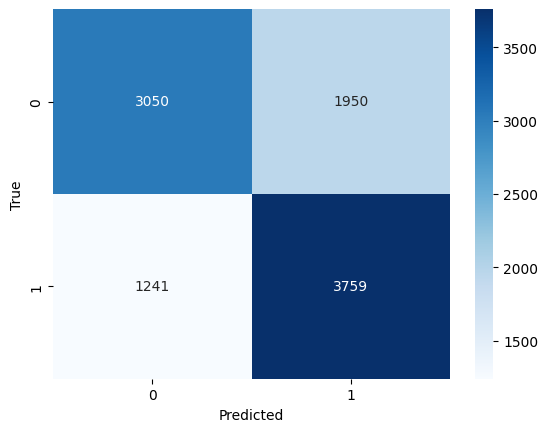

In [ ]:
metricas(y_pred_test_2, y_test_num)

Predigo el verdadero conjunto de test.

In [ ]:
y_pred_real = xgb_model_tfidf.predict(X_real)

y_pred_real = sentimiento_a_string(y_pred_real)

Exporto el modelo y las predicciones.

In [ ]:
df_test["sentimiento"] = y_pred_real

df_export = df_test.copy()

In [ ]:
df_export.drop(["review_es"], axis="columns", inplace=True)

In [ ]:
if exists('xgb_lower_token_stopwords_tfidf.csv') == False:
  df_export.to_csv("xgb_lower_token_stopwords_tfidf.csv")

In [ ]:
if exists('xgb_lower_token_stopwords_tfidf.joblib') == False:
  dump(xgb_model_tfidf, 'xgb_lower_token_stopwords_tfidf.joblib')

# Otro Preproceso

Pruebo con un dataset preprocesado de otra manera. Regex para limpieza, lematizacion, ner, iob y negacion de palabras.

In [ ]:
df_train = pd.read_csv("/content/drive/MyDrive/train-preprocessed.csv", index_col=0)

In [ ]:
df_test = pd.read_csv("/content/drive/MyDrive/test-preprocessed.csv", index_col=0)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(df_train.review_es, df_train.sentimiento, test_size=0.2, random_state=13, stratify=df_train.sentimiento)

Convierto los sentimientos a numero.

In [ ]:
y_train_num = y_train.map(lambda x: 0 if x == 'negativo' else 1)
y_test_num = y_test.map(lambda x: 0 if x == 'negativo' else 1)

In [ ]:
params_grid = {
  'booster': ['gblinear', 'gbtree', 'dart'],
  'n_estimators': range(10, 100),
  'max_depth': range(6, 100),
  'learning_rate': np.linspace(0, 1, 500),
  'min_child_weight': range(0, 20),
  'colsample_bytree': np.linspace(0, 1),
  'reg_alpha': np.linspace(0, 1, 500),
  'reg_lambda': np.linspace(0, 1, 500),
  'min_split_loss': range(0, 50)
}

### TFIDF

Formo la bag of words.

In [ ]:
tfidfvec = TfidfVectorizer(ngram_range=(1,3),
                           min_df=20)

X_train_bag = tfidfvec.fit_transform(X_train)
X_test_bag = tfidfvec.transform(X_test)
X_real = tfidfvec.transform(df_test["review_es"])

Busco el mejor modelo.

In [ ]:
xgb_base = xgb.XGBClassifier()

if exists('xgb_model_regex_lema_ner_iob_negacion_ngram_tfidf.joblib') == False:
  randomcv = RandomizedSearchCV(xgb_base,
                                params_grid,
                                cv=5,
                                scoring='f1_micro',
                                n_iter=5,
                                random_state=13)

  randomcv = randomcv.fit(X_train_bag, y_train_num)

  print(str(randomcv.best_params_))
  print(str(randomcv.best_score_))

  xgb_tfidf_ngram = xgb.XGBClassifier()
  xgb_tfidf_ngram.set_params(**randomcv.best_params_)
else:
  xgb_tfidf_ngram = load('xgb_model_regex_lema_ner_iob_negacion_ngram_tfidf.joblib')

Entreno el modelo y hago las predicciones sobre el conjunto de test.

              precision    recall  f1-score   support

           0       0.86      0.84      0.85      5000
           1       0.84      0.86      0.85      5000

    accuracy                           0.85     10000
   macro avg       0.85      0.85      0.85     10000
weighted avg       0.85      0.85      0.85     10000



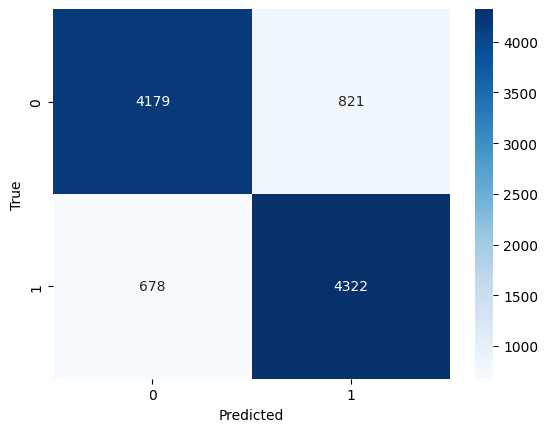

In [ ]:
xgb_tfidf_ngram.fit(X_train_bag, y_train_num)
y_pred_test_4 = xgb_tfidf_ngram.predict(X_test_bag)
metricas(y_pred_test_4, y_test_num)

Hago las predicciones sobre el verdadero conjunto de test de kaggle.

In [ ]:
y_pred_real = xgb_tfidf_ngram.predict(X_real)

y_pred_real = sentimiento_a_string(y_pred_real)

Creo un nuevo dataframe y exporto las predicciones.

In [ ]:
df_test["sentimiento"] = y_pred_real

df_export = df_test.copy()
df_export.drop(["review_es"], axis="columns", inplace=True)
df_export.drop(["texto_preprocesado"], axis="columns", inplace=True)
df_export.drop(["lang"], axis="columns", inplace=True)

In [ ]:
if exists('xgb_model_regex_lema_ner_iob_negacion_ngram_tfidf.csv') == False:
  df_export.to_csv("xgb_model_regex_lema_ner_iob_negacion_ngram_tfidf.csv")

Exporto el modelo.

In [ ]:
if exists('xgb_model_regex_lema_ner_iob_negacion_ngram_tfidf.joblib') == False:
  dump(xgb_tfidf_ngram, 'xgb_model_regex_lema_ner_iob_negacion_ngram_tfidf.joblib')

### Countvectorizer

In [ ]:
vec = CountVectorizer()

X_train_bag = vec.fit_transform(X_train)
X_test_bag = vec.transform(X_test)
X_real = vec.transform(df_test["review_es"])

In [ ]:
xgb_base = xgb.XGBClassifier(device="cuda")

if exists('xgb_model_regex_lema_ner_iob_negacion.joblib') == False:
  randomcv = RandomizedSearchCV(xgb_base,
                                params_grid,
                                cv=5,
                                scoring='f1_micro',
                                n_iter=5,
                                random_state=13)

  randomcv = randomcv.fit(X_train_bag, y_train_num)

  print(str(randomcv.best_params_))
  print(str(randomcv.best_score_))

  xgb_lema_iob_regex_ner = xgb.XGBClassifier()
  xgb_lema_iob_regex_ner.set_params(**randomcv.best_params_)
else:
  xgb_lema_iob_regex_ner = load('xgb_model_regex_lema_ner_iob_negacion.joblib')

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [13:56:22] WARNING: /workspace/src/context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [13:56:32] WARNING: /workspace/src/context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [13:56:40] WARNING: /workspace/src/context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [13:56:50] WARNING: /workspace/src/context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [13:56:59] WARNING: /workspace/src/context.cc:44: No visible GPU is found, setting device to CPU.


{'reg_lambda': 0.0, 'reg_alpha': 0.1282565130260521, 'n_estimators': 95, 'min_split_loss': 24, 'min_child_weight': 1, 'max_depth': 35, 'learning_rate': 0.23046092184368736, 'device': 'cuda', 'colsample_bytree': 0.1020408163265306, 'booster': 'gbtree'}
0.8351749999999999


In [ ]:
randomcv.best_params_

In [ ]:
xgb_lema_iob_regex_ner.fit(X_train_bag, y_train_num)
y_pred_test_3 = xgb_lema_iob_regex_ner.predict(X_test_bag)

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [13:59:27] WARNING: /workspace/src/context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


              precision    recall  f1-score   support

           0       0.85      0.82      0.84      5000
           1       0.83      0.85      0.84      5000

    accuracy                           0.84     10000
   macro avg       0.84      0.84      0.84     10000
weighted avg       0.84      0.84      0.84     10000



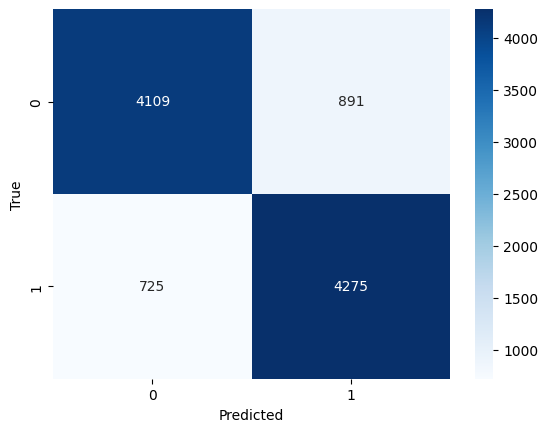

In [ ]:
metricas(y_pred_test_3, y_test_num)

In [ ]:
y_pred_real = xgb_lema_iob_regex_ner.predict(X_real)

y_pred_real = sentimiento_a_string(y_pred_real)

In [ ]:
df_test["sentimiento"] = y_pred_real

df_export = df_test.copy()

In [ ]:
df_export.drop(["review_es"], axis="columns", inplace=True)

In [ ]:
df_export.drop(["texto_preprocesado"], axis="columns", inplace=True)

In [ ]:
df_export.drop(["lang"], axis="columns", inplace=True)

In [ ]:
if exists('xgb_model_regex_lema_ner_iob_negacion.csv') == False:
  df_export.to_csv("xgb_model_regex_lema_ner_iob_negacion.csv")

In [ ]:
if exists('xgb_model_regex_lema_ner_iob_negacion.joblib') == False:
  dump(xgb_lema_iob_regex_ner, 'xgb_model_regex_lema_ner_iob_negacion.joblib')

Pruebo lo mismo pero con n gramas.

In [ ]:
vec = CountVectorizer(ngram_range=(1,3), min_df=20)

X_train_bag = vec.fit_transform(X_train)
X_test_bag = vec.transform(X_test)
X_real = vec.transform(df_test["review_es"])

In [ ]:
xgb_base = xgb.XGBClassifier(device="cuda")

if exists('xgb_model_regex_lema_ner_iob_negacion_ngram.joblib') == False:
  randomcv = RandomizedSearchCV(xgb_base,
                                params_grid,
                                cv=5,
                                scoring='f1_micro',
                                n_iter=5,
                                random_state=13)

  randomcv = randomcv.fit(X_train_bag, y_train_num)

  print(str(randomcv.best_params_))
  print(str(randomcv.best_score_))

  xgb_ngram = xgb.XGBClassifier()
  xgb_ngram.set_params(**randomcv.best_params_)
else:
  xgb_ngram = load('xgb_model_regex_lema_ner_iob_negacion_ngram.joblib')

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [22:36:40] WARNING: /workspace/src/context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


              precision    recall  f1-score   support

           0       0.86      0.83      0.84      5000
           1       0.83      0.86      0.85      5000

    accuracy                           0.84     10000
   macro avg       0.84      0.84      0.84     10000
weighted avg       0.84      0.84      0.84     10000



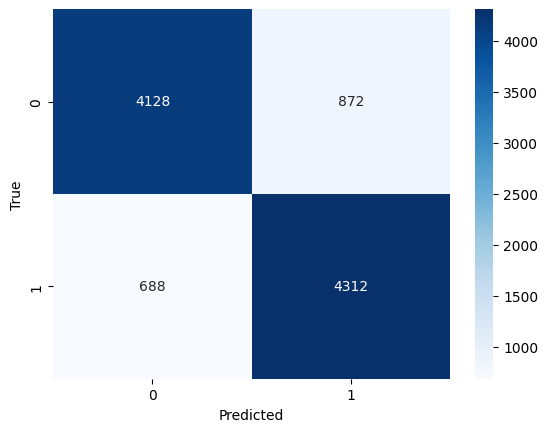

In [ ]:
xgb_ngram.fit(X_train_bag, y_train_num)
y_pred_test_4 = xgb_ngram.predict(X_test_bag)
metricas(y_pred_test_4, y_test_num)

In [ ]:
y_pred_real = xgb_ngram.predict(X_real)

y_pred_real = sentimiento_a_string(y_pred_real)

In [ ]:
df_test["sentimiento"] = y_pred_real

df_export = df_test.copy()
df_export.drop(["review_es"], axis="columns", inplace=True)
df_export.drop(["texto_preprocesado"], axis="columns", inplace=True)
df_export.drop(["lang"], axis="columns", inplace=True)

In [ ]:
if exists('xgb_model_regex_lema_ner_iob_negacion_ngram.csv') == False:
  df_export.to_csv("xgb_model_regex_lema_ner_iob_negacion_ngram.csv")

In [ ]:
if exists('xgb_model_regex_lema_ner_iob_negacion_ngram.joblib') == False:
  dump(xgb_ngram, 'xgb_model_regex_lema_ner_iob_negacion_ngram.joblib')

# Búsqueda de rango de híperparametros

Busco, gráficamente, las regiones de mejores híperparametros.

In [ ]:
params_grid = {
  'booster': ['gblinear', 'gbtree'],
  'n_estimators': range(1, 30),
  'max_depth': range(1, 50),
  'learning_rate': np.linspace(0, 1),
  'min_child_weight': range(0, 20),
  'colsample_bytree': np.linspace(0, 1),
  'reg_alpha': np.linspace(0, 1),
  'reg_lambda': np.linspace(0, 1),
  'min_split_loss': range(0, 50)
}

Busco primero con RandomizedSearch Cross Validation con 50 iteraciones.

In [ ]:
xgb_base = xgb.XGBClassifier()

if exists('xgb_randomsearch_amplio.joblib') == False:
  randomcv = RandomizedSearchCV(xgb_base,
                                params_grid,
                                cv=5,
                                scoring='f1_micro',
                                n_iter=50,
                                random_state=13)

  randomcv = randomcv.fit(X_train_bag, y_train_num)

  print(str(randomcv.best_params_))
  print(str(randomcv.best_score_))

  xgb_tst = xgb.XGBClassifier()
  xgb_tst.set_params(**randomcv.best_params_)
else:
  xgb_tst = load('xgb_randomsearch_amplio.joblib')

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [15:52:17] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "colsample_bytree", "max_depth", "min_child_weight", "min_split_loss" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [15:52:19] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "colsample_bytree", "max_depth", "min_child_weight", "min_split_loss" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [15:52:20] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "colsample_bytree", "max_depth", "min_child_weight", "min_split_loss" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [15:52:22] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "colsample_bytree", "max_depth", "min_child_weight", "min_split_loss" } ar

{'reg_lambda': 0.44897959183673464, 'reg_alpha': 0.7346938775510203, 'n_estimators': 26, 'min_split_loss': 21, 'min_child_weight': 19, 'max_depth': 31, 'learning_rate': 0.32653061224489793, 'colsample_bytree': 0.8979591836734693, 'booster': 'gbtree'}
0.8326749999999998


Guardo todos los scores en un dataframe para graficarlos.

In [ ]:
if exists("df_graficos_randomsearch_amplio.csv") == False:
  df_graf = pd.DataFrame()
  df_graf['n_estimators'] = randomcv.cv_results_['param_n_estimators'].data
  df_graf['booster'] = randomcv.cv_results_['param_booster'].data
  df_graf['colsample_bytree'] = randomcv.cv_results_['param_colsample_bytree'].data
  df_graf['learning_rate'] = randomcv.cv_results_['param_learning_rate'].data
  df_graf['max_depth'] = randomcv.cv_results_['param_max_depth'].data
  df_graf['min_child_weight'] = randomcv.cv_results_['param_min_child_weight'].data
  df_graf['min_split_loss'] = randomcv.cv_results_['param_min_split_loss'].data
  df_graf['reg_alpha'] = randomcv.cv_results_['param_reg_alpha'].data
  df_graf['reg_lambda'] = randomcv.cv_results_['param_reg_lambda'].data
  df_graf['score'] = randomcv.cv_results_['mean_test_score'].data
else:
  df_graf = pd.read_csv("df_graficos_randomsearch_amplio.csv")

Grafico los scores de cada híperparametro

<Axes: xlabel='n_estimators', ylabel='score'>

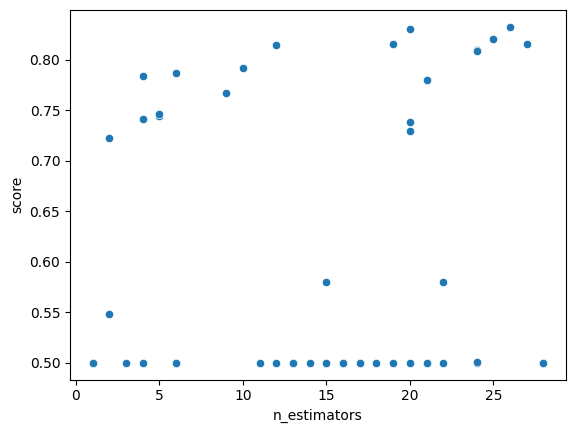

In [ ]:
sns.scatterplot(x=df_graf.n_estimators, y=df_graf.score)

<Axes: xlabel='learning_rate', ylabel='score'>

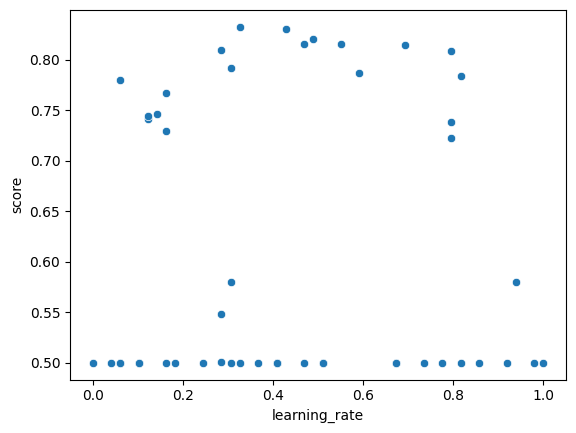

In [ ]:
sns.scatterplot(x=df_graf.learning_rate, y=df_graf.score)

<Axes: xlabel='max_depth', ylabel='score'>

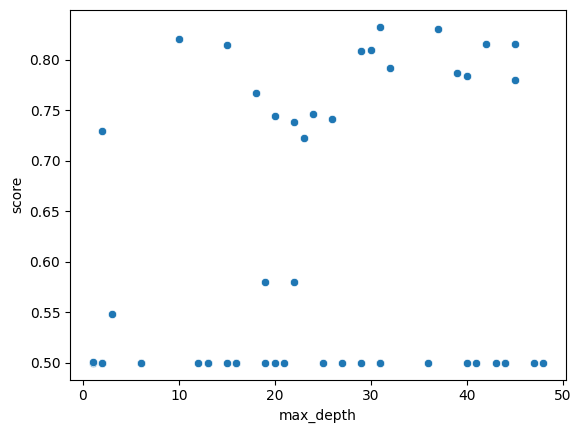

In [ ]:
sns.scatterplot(x=df_graf.max_depth, y=df_graf.score)

<Axes: xlabel='reg_alpha', ylabel='score'>

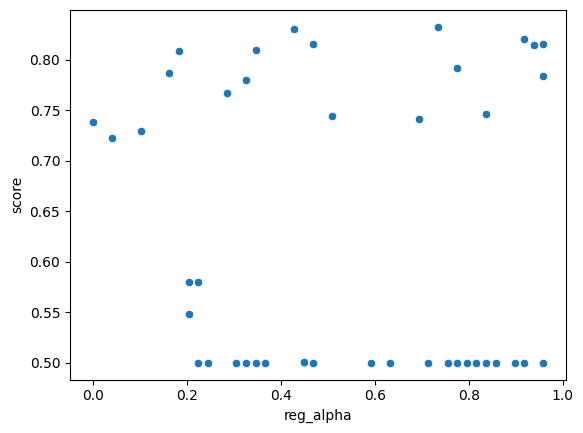

In [ ]:
sns.scatterplot(x=df_graf.reg_alpha, y=df_graf.score)

<Axes: xlabel='reg_lambda', ylabel='score'>

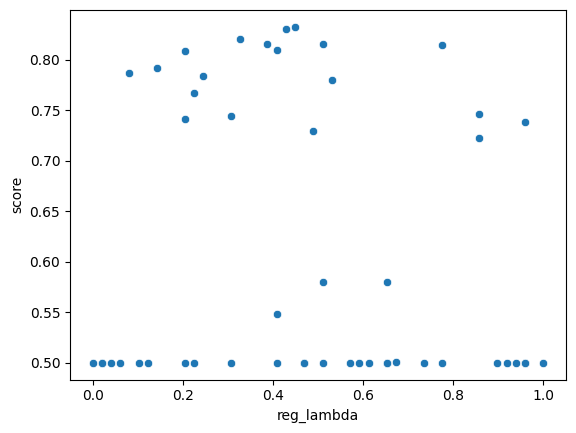

In [ ]:
sns.scatterplot(x=df_graf.reg_lambda, y=df_graf.score)

<Axes: xlabel='min_child_weight', ylabel='score'>

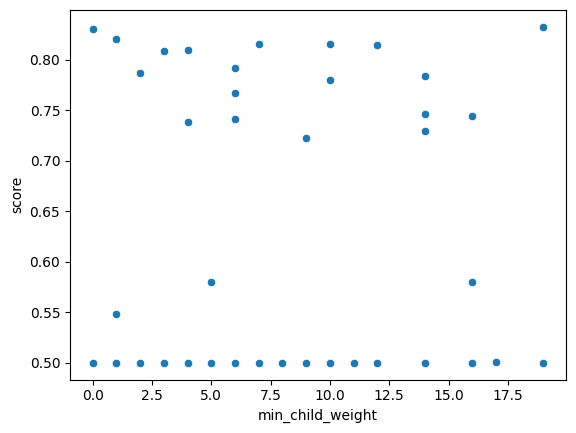

In [ ]:
sns.scatterplot(x=df_graf.min_child_weight, y=df_graf.score)

<Axes: xlabel='colsample_bytree', ylabel='score'>

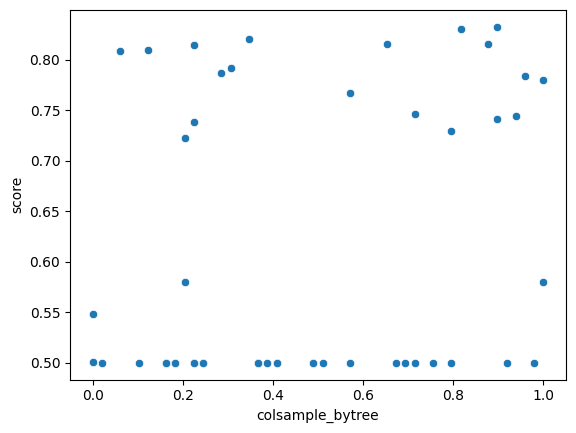

In [ ]:
sns.scatterplot(x=df_graf.colsample_bytree, y=df_graf.score)

<Axes: xlabel='min_split_loss', ylabel='score'>

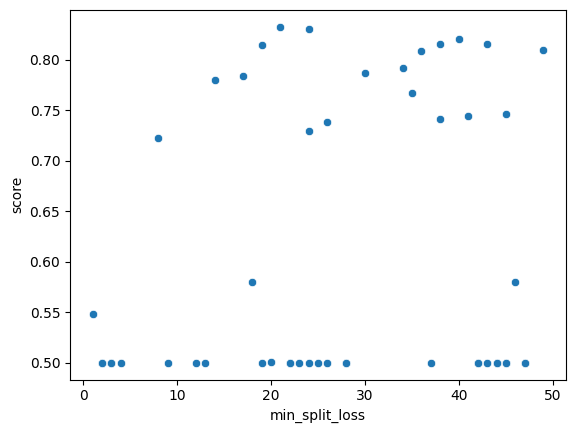

In [ ]:
sns.scatterplot(x=df_graf.min_split_loss, y=df_graf.score)

Guardo el modelo y los datos.

              precision    recall  f1-score   support

           0       0.82      0.83      0.83      4931
           1       0.84      0.82      0.83      5069

    accuracy                           0.83     10000
   macro avg       0.83      0.83      0.83     10000
weighted avg       0.83      0.83      0.83     10000



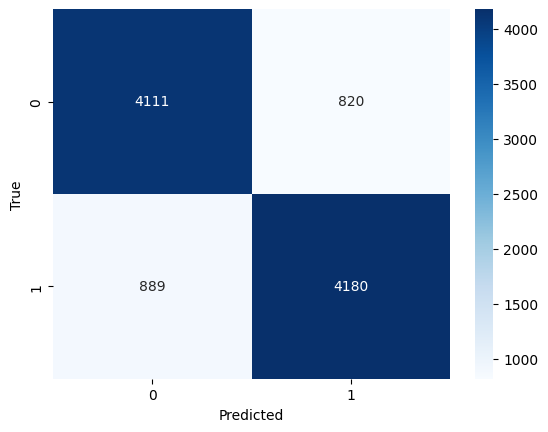

In [ ]:
xgb_tst.fit(X_train_bag, y_train_num)
y_pred = xgb_tst.predict(X_test_bag)
metricas(y_test_num, y_pred)

In [ ]:
y_pred_real = xgb_tst.predict(X_real)

In [ ]:
df_export = df_test.copy()
df_export.drop(["review_es"], axis="columns", inplace=True)
df_export.drop(["texto_preprocesado"], axis="columns", inplace=True)
df_export.drop(["lang"], axis="columns", inplace=True)
df_export['sentimiento'] = sentimiento_a_string(y_pred_real)
df_export.to_csv("xgb_randomsearch_amplio.csv")

In [ ]:
dump(xgb_tst, "xgb_randomsearch_amplio.joblib")

['xgb_tst.joblib']

In [ ]:
df_graf.to_csv("df_graficos_randomsearch_amplio.csv")

# Optimización de hiperparámetros

Ahora pruebo, en base a los gráficos, optimizar los híperparametros dentro de un rango en el que dan los mejores resultados.

In [ ]:
params_grid = {
  'booster': ['gbtree'],
  'n_estimators': range(20, 25),
  'max_depth': range(30, 35),
  'learning_rate': np.linspace(0.3, 0.45, 5),
  #'min_child_weight': range(0, 20),
  'colsample_bytree': [0.85],
  'reg_alpha': [0.4], #np.linspace(0.4, 0.5),
  'reg_lambda': [0.8], #np.linspace(0.8, 1.0),
  'min_split_loss': [22], #range(20, 25)
}

Busco los híperparametros con grid search.

In [ ]:
xgb_base = xgb.XGBClassifier()

if exists("xgb_gridsearch.joblib") == False:
  gridcv = GridSearchCV(xgb_base,
                        params_grid,
                        cv=5,
                        scoring='f1_micro')

  gridcv.fit(X_train_bag, y_train_num)

  xgb_gridsearch = xgb.XGBClassifier()
  xgb_gridsearch.set_params(**gridcv.best_params_)
else:
  xgb_gridsearch = load("xgb_gridsearch.joblib")

Realizo las predicciones y grafico las matriz de confusión.

              precision    recall  f1-score   support

           0       0.83      0.84      0.83      4939
           1       0.84      0.83      0.84      5061

    accuracy                           0.84     10000
   macro avg       0.84      0.84      0.84     10000
weighted avg       0.84      0.84      0.84     10000



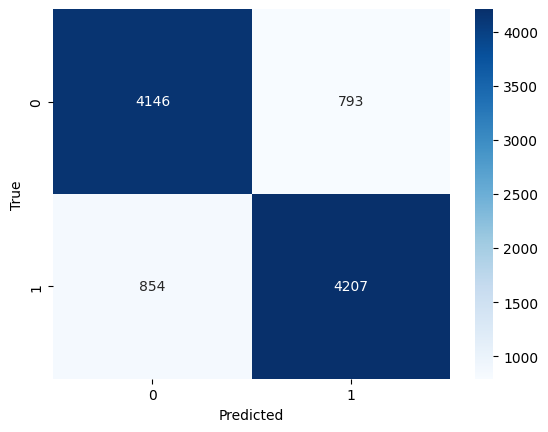

In [ ]:
xgb_gridsearch.fit(X_train_bag, y_train_num)
y_pred = xgb_gridsearch.predict(X_test_bag)
metricas(y_test_num, y_pred)

Hago las predicciones sobre el verdadero conjunto de test.

In [ ]:
y_real_pred = xgb_gridsearch.predict(X_real)

Exporto el modelo y los resultados

In [ ]:
df_export = df_test.copy()
df_export.drop(["review_es"], axis="columns", inplace=True)
df_export.drop(["texto_preprocesado"], axis="columns", inplace=True)
df_export.drop(["lang"], axis="columns", inplace=True)
df_export['sentimiento'] = sentimiento_a_string(y_real_pred)

In [ ]:
df_export.to_csv("xgb_gridsearch.csv")

In [ ]:
dump(xgb_gridsearch, "xgb_gridsearch.joblib")

['xgb_gridsearch.joblib']

# BayesSearch

Por último pruebo buscar los mejores híperparametros mediante BayesSearch.

In [ ]:
!pip install scikit-optimize

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 107.8/107.8 kB 3.0 MB/s eta 0:00:00


In [ ]:
from skopt import BayesSearchCV
from skopt.space import Real, Categorical, Integer

In [ ]:
params_grid = {
  'booster': ['gblinear', 'gbtree'],
  'n_estimators': Integer(1, 30),
  'learning_rate': np.linspace(0, 1),
  'reg_alpha': np.linspace(0, 1),
  'reg_lambda': np.linspace(0, 1),
}

In [ ]:
xgb_base = xgb.XGBClassifier()

if exists("xgb_bayessearch.joblib") == False:
  gridcv = BayesSearchCV(xgb_base,
                        params_grid,
                        cv=5,
                        n_iter=50,
                        scoring='f1_micro')

  gridcv.fit(X_train_bag, y_train_num)

  xgb_bayessearch = xgb.XGBClassifier()
  xgb_bayessearch.set_params(**gridcv.best_params_)
else:
  xgb_bayessearch = load("xgb_bayessearch.joblib")

/usr/local/lib/python3.10/dist-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point ['gbtree', 0.5918367346938775, 30, 0.5918367346938775, 0.2040816326530612] before, using random point ['gbtree', 0.18367346938775508, 21, 0.9387755102040816, 0.14285714285714285]
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point ['gbtree', 0.4897959183673469, 30, 0.42857142857142855, 0.36734693877551017] before, using random point ['gbtree', 0.6530612244897959, 11, 0.8571428571428571, 0.061224489795918366]
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point ['gbtree', 0.26530612244897955, 30, 0.42857142857142855, 0.36734693877551017] before, using random point ['gblinear', 0.5918367346938775, 25, 0.16326530612244897, 0.04081632653061224]
  warnings.warn(
/usr/local/lib/pyt

              precision    recall  f1-score   support

           0       0.83      0.80      0.82      5000
           1       0.81      0.84      0.82      5000

    accuracy                           0.82     10000
   macro avg       0.82      0.82      0.82     10000
weighted avg       0.82      0.82      0.82     10000



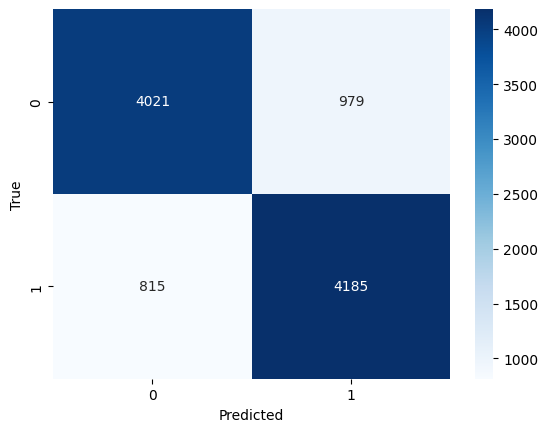

In [ ]:
xgb_bayessearch.fit(X_train_bag, y_train_num)
y_pred_test = xgb_bayessearch.predict(X_test_bag)
metricas(y_pred_test, y_test_num)

In [ ]:
y_pred_real = xgb_bayessearch.predict(X_real)

In [ ]:
df_test["sentimiento"] = sentimiento_a_string(y_pred_real)

df_export = df_test.copy()
df_export.drop(["review_es"], axis="columns", inplace=True)
df_export.drop(["texto_preprocesado"], axis="columns", inplace=True)
df_export.drop(["lang"], axis="columns", inplace=True)
df_export.to_csv("xgb_bayessearch_ner_iob_lema_negacion.csv")

In [ ]:
dump(xgb_bayessearch, "xgb_bayessearch.joblib")

['xgb_bayessearch.joblib']